In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import numpy as np
import random

In [ ]:
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),
target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),
target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


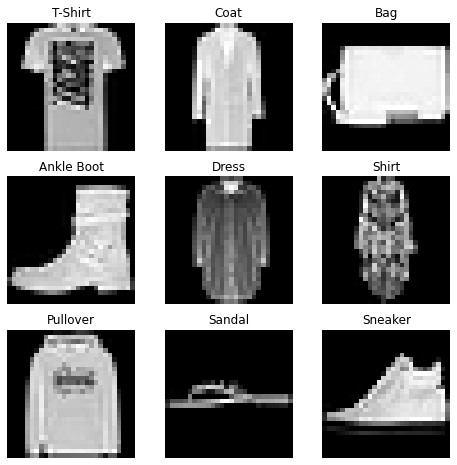

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
lab = set()
while(len(lab) <= 8):
  sample_idx = torch.randint(len(train_data), size=(1,)).item()
  img, label = train_data[sample_idx]
  label = label.argmax().item()
  if label not in lab:
    lab.add(label)
    figure.add_subplot(rows, cols, len(lab))
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
class NeuralNetwork:
    def __init__(self, layers=[784, 512, 512, 10], random=torch.randn, device=device):
        self.params = {}
        self.params['weight1'] = random(layers[0], layers[1], requires_grad=True, device=device)
        self.params['weight2'] = random(layers[1], layers[2], requires_grad=True, device=device)
        self.params['weight3'] = random(layers[2], layers[3], requires_grad=True, device=device)
        self.params['bias1'] = random(layers[1], requires_grad=True, device=device)
        self.params['bias2'] = random(layers[2], requires_grad=True, device=device)
        self.params['bias3'] = random(layers[3], requires_grad=True, device=device)


    def linear_relu(self, out, weight, bias): 
       return torch.clamp(torch.matmul(out, weight) + bias, min=0)


    def softmax(self, x):
        means = torch.mean(x, dim=1, keepdim=True)
        x_exp = x-means
        x_exp_sum = torch.logsumexp(x_exp, dim=1, keepdim=True)
        return x_exp - x_exp_sum


    def forward(self, input):
        y1 = self.linear_relu(input, self.params['weight1'], self.params['bias1'])
        y = self.linear_relu(y1, self.params['weight2'], self.params['bias2'])
        self.params['output'] = self.softmax(torch.matmul(y, self.params['weight3']) + self.params['bias3'])
        return self.params['output']

In [ ]:
def cross_entropy_loss(y, target):
    loss=0
    a = target * y
    loss = -a.sum() / a.shape[0] 
    return loss
    

In [ ]:
def train(model, dataloader, loss_fn, lr=0.001):
    size = len(dataloader.dataset)
    l, l2 = 0, []
    
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        x = X.reshape(X.shape[0],784)
        y = model.forward(x)
        loss = loss_fn(y, Y)
        l += loss / 100
        loss.backward()
        with torch.no_grad():
            model.params['weight1'] -= lr * model.params['weight1'].grad
            model.params['weight2'] -= lr * model.params['weight2'].grad
            model.params['weight3'] -= lr * model.params['weight3'].grad
            model.params['bias1'] -= lr * model.params['bias1'].grad
            model.params['bias2'] -= lr * model.params['bias2'].grad
            model.params['bias3'] -= lr * model.params['bias3'].grad

        model.params['weight1'].grad.zero_()
        model.params['weight2'].grad.zero_()
        model.params['weight3'].grad.zero_()
        model.params['bias1'].grad.zero_()
        model.params['bias2'].grad.zero_()
        model.params['bias3'].grad.zero_()


        if batch % 100 == 99:
            loss1, current = l.item(), batch * len(X)
            print(f"loss: {loss1:>7f}  [{current:>5d}/{size:>5d}]")
            l2.append(loss1)
            l = 0
  
    return l2

In [ ]:
def test(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in dataloader:
            X, y = X.to(device), y.to(device)
            x = X.reshape(X.shape[0],784)
            pred = model.forward(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
epochs = 5
model, l = NeuralNetwork(), []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(model, train_dataloader, cross_entropy_loss)
    test(model, test_dataloader, cross_entropy_loss)
    l += train_loss
print("Done!")

Epoch 1
-------------------------------
loss: 680.132690  [ 6336/60000]
loss: 284.138580  [12736/60000]
loss: 248.168747  [19136/60000]
loss: 194.200043  [25536/60000]
loss: 172.221039  [31936/60000]
loss: 155.336060  [38336/60000]
loss: 143.367325  [44736/60000]
loss: 135.402222  [51136/60000]
loss: 124.031883  [57536/60000]
Test Error: 
 Accuracy: 69.2%, Avg loss: 220.932487 

Epoch 2
-------------------------------
loss: 113.451355  [ 6336/60000]
loss: 95.281532  [12736/60000]
loss: 104.953171  [19136/60000]
loss: 95.582726  [25536/60000]
loss: 93.066452  [31936/60000]
loss: 90.378334  [38336/60000]
loss: 82.326813  [44736/60000]
loss: 85.705750  [51136/60000]
loss: 80.234856  [57536/60000]
Test Error: 
 Accuracy: 79.8%, Avg loss: 86.194703 

Epoch 3
-------------------------------
loss: 73.129631  [ 6336/60000]
loss: 72.126503  [12736/60000]
loss: 67.557594  [19136/60000]
loss: 68.890640  [25536/60000]
loss: 61.384266  [31936/60000]
loss: 68.609779  [38336/60000]
loss: 68.222343  [

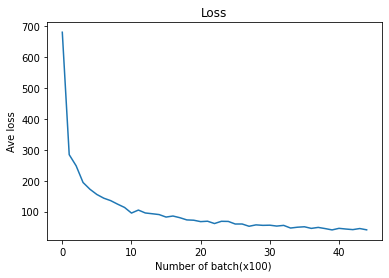

In [ ]:
plt.plot(l)
plt.title('Loss')
plt.xlabel("Number of batch(x100) ")
plt.ylabel("Ave loss")
plt.show()

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
r = random.randint(0, len(test_data))
x, y = test_data[r][0].to(device), test_data[r][1].to(device)
x = x.reshape(1, 784)
with torch.no_grad():
    pred = model.forward(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y.argmax(0)]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Sneaker", Actual: "Sneaker"
